<a href="https://colab.research.google.com/github/Sahil-Singh2002/Solving-PDE-s-using-Deep-Learning-Algorithms/blob/main/2Dinitial_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2D case f(x,y) = 1

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

In [37]:
################################################################################
# 1. Domain Checks:  Now everything is in the form  a^T x >= b.
################################################################################

def domain_1(x: np.ndarray) -> bool:
    checks = [
        np.dot(np.array([1, 0]), x) >= 0,    # x >= 0
        np.dot(np.array([0, 1]), x) >= 0,    # y >= 0
        np.dot(np.array([-1, -1]), x) >= -1  # x + y <= 1
    ]
    return all(checks)

def domain_2(x: np.ndarray, w_i: np.ndarray, b_i: float) -> bool:
    return domain_1(x) and (np.dot(w_i, x) >= b_i)

def domain_3(x: np.ndarray, w_i: np.ndarray, b_i: float, w_j: np.ndarray, b_j: float) -> bool:
    return domain_2(x, w_i, b_i) and (np.dot(w_j, x) >= b_j)

################################################################################
# 2. Utility functions: distance, reorder, duplicates, etc.
################################################################################

def euclidean_distance(coord1: np.ndarray, coord2: np.ndarray) -> float:
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(coord1 - coord2)

def reorder_nodes(reference_node: np.ndarray, nodes_to_sort: list[dict]) -> list[dict]:
    """
    Reorders nodes based on proximity to a reference point.
    The closest node is chosen next, and so on.
    """
    ordered_nodes = []
    remaining_nodes = nodes_to_sort.copy()
    current_reference = reference_node

    while remaining_nodes:
        closest_node = min(
            remaining_nodes,
            key=lambda node: euclidean_distance(current_reference, node["coordinates"])
        )
        ordered_nodes.append(closest_node)
        remaining_nodes.remove(closest_node)
        current_reference = closest_node["coordinates"]

    return ordered_nodes

def remove_duplicate_coordinates(nodes):
    """Removes nodes with identical coordinates (within a tolerance)."""
    unique_nodes = []
    seen_coords = set()

    for node in nodes:
        coords_rounded = tuple(np.round(node["coordinates"], 100))
        if coords_rounded not in seen_coords:
            seen_coords.add(coords_rounded)
            unique_nodes.append(node)
    return unique_nodes

################################################################################
# 3. Step 1: Solve boundary pair intersections.
#    Now each boundary is  a^T x = b  in ">= b" sense.
################################################################################

def step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Solve the linear systems for the three pairs of boundaries:
      1) boundary_1 & boundary_2
      2) boundary_1 & boundary_3
      3) boundary_2 & boundary_3

    This yields the triangle's vertices in 'Option A' style.
    """
    # Solve  a^T x = b  with two lines
    A12 = np.array([boundary_1, boundary_2])  # e.g. x=0 & y=0 in the old sense
    b12 = np.array([b1, b2], dtype=float)
    x12 = np.linalg.solve(A12, b12)

    A13 = np.array([boundary_1, boundary_3])
    b13 = np.array([b1, b3], dtype=float)
    x13 = np.linalg.solve(A13, b13)

    A23 = np.array([boundary_2, boundary_3])
    b23 = np.array([b2, b3], dtype=float)
    x23 = np.linalg.solve(A23, b23)

    nodes_1 = [
        {"node": 1, "coordinates": x12, "A": A12, "b": b12},
        {"node": 2, "coordinates": x13, "A": A13, "b": b13},
        {"node": 3, "coordinates": x23, "A": A23, "b": b23},
    ]

    # Debug
    #print("===== step_1: original 3 boundary intersections =====")
    #for node in nodes_1:
        #print(f"Node {node['node']} => coords={node['coordinates']}")
    # print()
    return nodes_1

################################################################################
# 4. Step 2: Filter those nodes by domain_2 and add intersections with hyperplane
################################################################################
def step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i):
    nodes_1 = step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3)
    nodes_1_filtered = [n for n in nodes_1 if domain_2(n["coordinates"], w_i, b_i)]

    # Find intersections with ALL boundaries (including hyperplane vs. triangle edges)
    valid_intersections = []
    boundaries = [
        (boundary_1, b1),
        (boundary_2, b2),
        (boundary_3, b3)
    ]
    for boundary, b_boundary in boundaries:
        A = np.vstack([w_i, boundary])
        try:
            x = np.linalg.solve(A, [b_i, b_boundary])
            if domain_1(x):
                valid_intersections.append({
                    "node": len(valid_intersections) + 4,
                    "coordinates": x,
                    "A": A,
                    "b": [b_i, b_boundary]
                })
        except np.linalg.LinAlgError:
            continue

    # Merge and sort nodes
    merged = nodes_1_filtered + valid_intersections
    unique_nodes = remove_duplicate_coordinates(merged)
    if unique_nodes:
        centroid = np.mean([n["coordinates"] for n in unique_nodes], axis=0)
        unique_nodes.sort(key=lambda n: np.arctan2(
            n["coordinates"][1] - centroid[1],
            n["coordinates"][0] - centroid[0]
        ))
    return unique_nodes


def step_3(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j):
    nodes_2 = step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i)
    nodes_2_filtered = [n for n in nodes_2 if domain_3(n["coordinates"], w_i, b_i, w_j, b_j)]

    # Find intersections of w_j with all boundaries (including w_i)
    boundaries = [
        (boundary_1, b1), (boundary_2, b2), (boundary_3, b3), (w_i, b_i)
    ]
    valid_intersections = []
    node_counter = 7  # Start numbering new nodes from 7
    for boundary, b_boundary in boundaries:
        A = np.vstack([w_j, boundary])
        try:
            x = np.linalg.solve(A, [b_j, b_boundary])
            if domain_3(x, w_i, b_i, w_j, b_j): # domain_1(x) and
                valid_intersections.append({
                    "node": node_counter,
                    "coordinates": x,
                    "A": A,
                    "b": [b_j, b_boundary]
                })
                node_counter += 1
        except np.linalg.LinAlgError:
            continue

    merged = nodes_2_filtered + valid_intersections
    unique_nodes = remove_duplicate_coordinates(merged)
    if unique_nodes:
        centroid = np.mean([n["coordinates"] for n in unique_nodes], axis=0)
        unique_nodes.sort(key=lambda n: np.arctan2(
            n["coordinates"][1] - centroid[1],
            n["coordinates"][0] - centroid[0]
        ))
    return unique_nodes

###############################################
# Used for Plotting the hyperplanes and domain triangle
###############################################

def generate_uniform_hyperplanes(n):
    """Generates n uniformly spaced hyperplanes: vertical (x = c), horizontal (y = c), and diagonal (x + y = c)."""
    if n % 3 != 0:
        raise ValueError("Number of hyperplanes (n) must be a multiple of 3.")

    # Generate c values for vertical, horizontal, and diagonal lines
    num_lines = n // 3
    c_values = np.linspace(0, 1, num_lines + 2)[1:-1]  # Exclude the endpoints to avoid lines on the boundaries

    W, B = [], []

    # Vertical lines (x = c)
    for c in c_values:
        W.append(np.array([1, 0]))  # Normal vector for vertical lines
        B.append(c)

    # Horizontal lines (y = c)
    for c in c_values:
        W.append(np.array([0, 1]))  # Normal vector for horizontal lines
        B.append(c)

    # Diagonal lines (x + y = c)
    for c in c_values:
        W.append(np.array([1, -1]) )  # Normalized normal vector for diagonal lines
        B.append(c)  # Normalized offset

    return W, B

def plot_triangle_with_hyperplanes(n, ax):
    """Plots the triangle with vertical and horizontal hyperplanes (no shading)."""
    W, B = generate_uniform_hyperplanes(n)

    # Plot the triangle domain
    triangle = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
    ax.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=2, label='Triangle Domain')
    # Removed this line: ax.fill(...) to avoid shading inside the triangle

    # Plot hyperplanes without shading
    for w, b in zip(W, B):
        if np.array_equal(w, [1, 0]):  # Vertical hyperplane: x = c
            ax.axvline(x=b, color='blue', linestyle='--', alpha=0.7, label='Vertical Hyperplane')
        elif np.array_equal(w, [0, 1]):  # Horizontal hyperplane: y = c
            ax.axhline(y=b, color='red', linestyle='--', alpha=0.7, label='Horizontal Hyperplane')

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"n = {n} Hyperplanes")
    ax.grid(True, linestyle='--', alpha=0.5)

In [38]:
# Integragte / sum up the area using quadrature rule and the unique nodes based of the hyperplanes.
################################################################################
# The Partial-Sum "Area" Calculation (diagonalMatrix)
################################################################################

def diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i) -> float:
    nodes_poly = step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i)
    if len(nodes_poly) < 3:
        return 0.0

    # Identify active boundaries for each edge
    a_list = []
    b_list = []
    boundaries = [
        (boundary_1, b1),   # x >= 0
        (boundary_2, b2),   # y >= 0
        (boundary_3, b3),   # x + y <= 1
        (w_i, b_i)          # Hyperplane
    ]

    for i in range(len(nodes_poly)):
        p1 = nodes_poly[i]["coordinates"]
        p2 = nodes_poly[(i+1) % len(nodes_poly)]["coordinates"]
        for a, b in boundaries:
            if (abs(np.dot(a, p1) - b) < np.finfo(float).eps and
                abs(np.dot(a, p2) - b) < np.finfo(float).eps):
                a_list.append(a)
                b_list.append(b)
                break

    # Calculate area using corrected constraints
    summation = 0.0
    for i in range(len(a_list)):
        a, b = a_list[i], b_list[i]
        edge_len = euclidean_distance(
            nodes_poly[i]["coordinates"],
            nodes_poly[(i+1) % len(nodes_poly)]["coordinates"]
        )
        summation += (b / np.linalg.norm(a)) * edge_len
    return abs(summation) * 0.5

################################################################################
# The Partial-Sum "Area" Calculation (lowerMatrix)
################################################################################

def lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j) -> float:
    nodes_poly = step_3(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j)
    #if len(nodes_poly) < 3:
     #   return 0.0

    # Identify active boundaries for each edge
    boundaries = [
        (boundary_1, b1),   # x >= 0
        (boundary_2, b2),   # y >= 0
        (boundary_3, b3),   # x + y <= 1
        (w_i, b_i),         # First hyperplane
        (w_j, b_j)          # Second hyperplane
    ]

    a_list, b_list = [], []
    for i in range(len(nodes_poly)):
        p1 = nodes_poly[i]["coordinates"]
        p2 = nodes_poly[(i+1) % len(nodes_poly)]["coordinates"]
        for a, b in boundaries:
            if (abs(np.dot(a, p1) - b) < np.finfo(float).eps and
                abs(np.dot(a, p2) - b) < np.finfo(float).eps):
                a_list.append(a)
                b_list.append(b)
                break

    # Calculate area
    summation = 0.0
    for i in range(len(a_list)):
        a, b = a_list[i], b_list[i]
        edge_len = euclidean_distance(
            nodes_poly[i]["coordinates"],
            nodes_poly[(i+1) % len(nodes_poly)]["coordinates"]
        )
        summation += (b / np.linalg.norm(a)) * edge_len
    return abs(summation) * 0.5

################################################################################
# The Partial-Sum "Area" Calculation (lowerMatrix)
################################################################################

def compute_F_from_step1(boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Compute edge lengths (F) for the triangle formed by nodes from step_1.
    Calculate the area using the same summation formula as diagonalMatrix and lowerMatrix.
    """
    # Step 1: Get the triangle nodes
    nodes_1 = step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3)

    # Collect coordinates of the nodes
    coords = [node["coordinates"] for node in nodes_1]

    # Distances between consecutive nodes
    n = len(coords)
    F = np.zeros((n, 1))
    for i in range(n):
        j = (i + 1) % n  # Next node (cyclic indexing)
        F[i, 0] = euclidean_distance(coords[i], coords[j])

    #print("Edge lengths F (from step 1):")
    #print(F)

    # Attempt to match constraints (a_i, b_i) between consecutive nodes
    a_list = []
    b_list = []
    for i in range(n):
        j = (i + 1) % n
        Ai, bi = nodes_1[i]["A"], nodes_1[i]["b"]
        Aj, bj = nodes_1[j]["A"], nodes_1[j]["b"]
        # Match rows between Ai and Aj
        for idx_i, row_i in enumerate(Ai):
            for idx_j, row_j in enumerate(Aj):
                if np.allclose(row_i, row_j, atol=np.finfo(float).eps) and np.isclose(bi[idx_i], bj[idx_j], atol=np.finfo(float).eps):
                    a_list.append(row_i)
                    b_list.append(bi[idx_i])

    #print("Matched constraints (a_list, b_list):")
    #for a, b in zip(a_list, b_list):
    #    print(f"  a={a}, b={b}")
    #print()

    # Calculate area using the summation formula
    summation_result = 0.0
    for i in range(min(len(a_list), n)):
        beta_i = b_list[i]
        a_i = a_list[i]
        norm_a = np.linalg.norm(a_i)
        edge_len = F[i, 0]
        part = (beta_i / norm_a) * edge_len
        #print(f"Edge {i}: (b_i/||a_i||)*F[i]={beta_i}/{norm_a}*{edge_len}={part}")
        summation_result += part

    final_area = 0.5 * abs(summation_result)
    #print(f"** Summation result={summation_result}, final_area={final_area}")
    #print()

    return final_area

def MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Construct the MassMatrix and also calculate F vectors at different stages.
    """
    NoNeuron = len(W)
    MatrixM = np.zeros((NoNeuron, NoNeuron), dtype=np.float64)

    # Compute diagonal entries
    diagonal_values = np.array([
        diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i])
        for i in range(NoNeuron)
    ])
    np.fill_diagonal(MatrixM, diagonal_values)

    # Compute F_vector directly
    F_vector = diagonal_values.reshape(-1, 1)

    # Compute lower triangular part and reflect to upper part
    for i in range(1, NoNeuron):
        MatrixM[i, :i] = [
            lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i], W[j], B[j])
            for j in range(i)
        ]
        MatrixM[:i, i] = MatrixM[i, :i]  # Symmetric assignment

    # Compute area_step1
    area_step1 = compute_F_from_step1(boundary_1, boundary_2, boundary_3, b1, b2, b3)

    return MatrixM, F_vector, area_step1

def compute_f_integral(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_f, b_f):
    """Computes ∫ ReLU(w_f^T x - b_f) over the domain."""
    return diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_f, b_f)

def M_F_A(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3, w_f, b_f):
    """Optimized matrix construction with vectorization."""
    NoNeuron = len(W)
    MatrixM = np.zeros((NoNeuron, NoNeuron), dtype=np.float64)

    # Single-pass diagonal construction
    diag_vals = np.array([
        diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i])
        for i in range(NoNeuron)
    ])
    np.fill_diagonal(MatrixM, diag_vals)

    # Efficient lower triangle construction
    for i in range(1, NoNeuron):
        MatrixM[i, :i] = [
            lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i], W[j], B[j])
            for j in range(i)
        ]
        MatrixM[:i, i] = [
            lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[j], B[j], W[i], B[i])
            for j in range(i)
        ]

    # Vectorized F-vector calculation
    F_massmatrix = np.array([
        lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i], w_f, b_f)
        for i in range(NoNeuron)
    ]).reshape(-1, 1)

    return MatrixM, F_massmatrix, compute_f_integral(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_f, b_f)

def compute_cost(outer_c, MatrixM, F_massmatrix, area_step1):
    outer_c = np.asarray(outer_c).reshape(-1, 1)
    F_massmatrix = np.asarray(F_massmatrix).reshape(-1, 1)

    quadratic_term = outer_c.T @ MatrixM @ outer_c
    linear_term = 1*F_massmatrix.T @ outer_c

    cost = area_step1 - linear_term #quadratic_term + linear_term + area_step1
    print(f"cMc: {quadratic_term}")
    print(f"cF: {linear_term}")
    print(f"Area: {area_step1}")
    return cost.item()


def compute_cost_grad_c(outer_c, MatrixM, F_massmatrix):

    outer_c = np.asarray(outer_c).reshape(-1, 1)  # Ensure column vector
    F_massmatrix = np.asarray(F_massmatrix).reshape(-1, 1)  # Ensure column vector

    grad_c = 2*(MatrixM @ outer_c - F_massmatrix)

    return grad_c


def clean_solution(outer_c, tol=np.finfo(float).eps):
    """Round near-zero values to exact zeros."""
    outer_c = np.asarray(outer_c)
    outer_c[np.abs(outer_c) < tol] = 0.0
    return outer_c

def is_positive_definite(matrix, tol=np.finfo(float).eps):
    # Ensure symmetry (floating-point correction)
    matrix = (matrix + matrix.T) / 2
    # Compute eigenvalues
    eigvals = np.linalg.eigvalsh(matrix)  # For symmetric matrices
    # Check all eigenvalues > tolerance
    return np.all(eigvals > tol)

def is_positive_definite_cholesky(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False


if __name__ == "__main__":
    print("========== MAIN ==========")

    # Define the triangle boundaries
    boundary_1, b1 = np.array([1, 0]), 0.0
    boundary_2, b2 = np.array([0, 1]), 0.0
    boundary_3, b3 = np.array([-1, -1]), -1.0

    # Define hyperplanes
    n = 3
    W, B = generate_uniform_hyperplanes(n)

    #W = np.array([[np.sqrt(2)/2, -np.sqrt(2)/2],[np.sqrt(2)/2, np.sqrt(2)/2]])
    #B = np.array([-0.4, 0.4])

    # Compute the MassMatrix and F vectors
    MatrixM, F_massmatrix, area_step1 = MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3)
    print("Final MassMatrix:")
    print(MatrixM)

    print("integral over domain for f^2(x) = 1:", area_step1)
    print("F vector (from MassMatrix diagonal):", F_massmatrix)

    # go for maybe some for of QR
    outer_c = np.linalg.pinv(MatrixM) @ F_massmatrix
    #outer_c = np.linalg.solve(MatrixM, F_massmatrix)

    outer_c = clean_solution(outer_c)  # <-- CLEAN HERE

    print("Cleaned Outer Parameter:")
    print(outer_c)
    print("==========================")

    print("Final Cost:", compute_cost(outer_c, MatrixM, F_massmatrix, area_step1))

    # Check positive definiteness
    print("\nPositive Definiteness Checks:")
    print(f"Via eigenvalues: {is_positive_definite(MatrixM)}")
    print(f"Via Cholesky: {is_positive_definite_cholesky(MatrixM)}")

    #print(np.linalg.qr(MatrixM))

========== MAIN ==========
Final MassMatrix:
[[0.125  0.     0.0625]
 [0.     0.125  0.    ]
 [0.0625 0.     0.0625]]
integral over domain for f^2(x) = 1: 0.5
F vector (from MassMatrix diagonal): [[0.125 ]
 [0.125 ]
 [0.0625]]
Cleaned Outer Parameter:
[[1.]
 [1.]
 [0.]]
cMc: [[0.25]]
cF: [[0.25]]
Area: 0.5
Final Cost: 0.25000000000000006

Positive Definiteness Checks:
Via eigenvalues: True
Via Cholesky: True


ValueError: Number of hyperplanes (n) must be a multiple of 3.

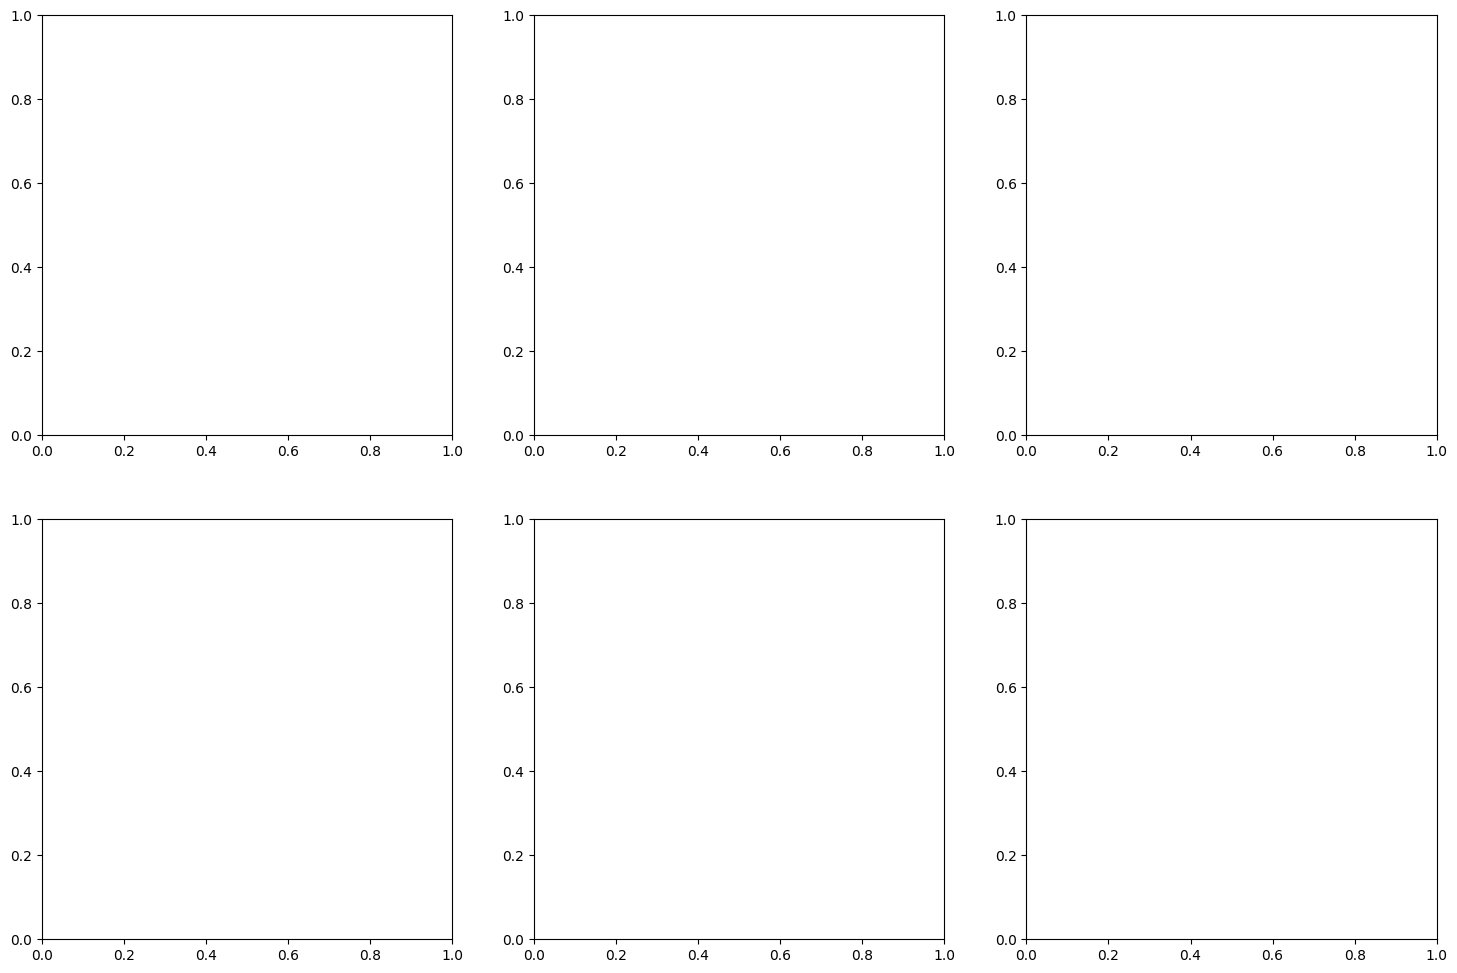

In [39]:

if __name__ == "__main__":
    max_iterations = 6
    initial_neurons = 2

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i in range(max_iterations):
        n = initial_neurons * (2 ** i)  # Doubling neurons each iteration
        plot_triangle_with_hyperplanes(n, axes[i])

    plt.suptitle("Triangle Domain with Increasing Number of Hyperplanes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Triangle boundaries (used later in MassMatrix_with_F)
    boundary_1, b1 = np.array([1, 0]), 0.0
    boundary_2, b2 = np.array([0, 1]), 0.0
    boundary_3, b3 = np.array([-1, -1]), -1.0

    costs, neuron_counts = [], []

    max_iterations = 6
    for iteration in tqdm(range(max_iterations), desc="Processing iterations"):
        num_neurons = initial_neurons * (2 ** iteration)

        # Generate uniformly spaced hyperplanes
        W, B = generate_uniform_hyperplanes(num_neurons)

        try:
            MatrixM, F_massmatrix, area_step1 = MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3)
            c_opt = clean_solution(np.linalg.lstsq(MatrixM, F_massmatrix, rcond=None)[0])
            cost = compute_cost(c_opt, MatrixM, F_massmatrix, area_step1)
            costs.append(cost)
            neuron_counts.append(num_neurons)
        except np.linalg.LinAlgError:
            print(f"Skipping {num_neurons} due to singular matrix")
            continue

        try:
            outer_c = clean_solution(np.linalg.lstsq(MatrixM, F_massmatrix, rcond=None)[0])
        except np.linalg.LinAlgError:
            print(f"Skipping {num_neurons} due to least squares issue")
            continue



    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(neuron_counts, costs, 'o-', markerfacecolor='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Neurons (log scale)')
    plt.ylabel(r'$\|\mathrm{Error}\| _{L^2}^2$ (log scale)')
    plt.title('Approximation Error vs Network Complexity')
    plt.grid(True, which='both', linestyle='--')
    plt.show()



#2D function fitting with f(x) = ReLU(...)^0

In [ ]:
################################################################################
# Interactive 3D Visualization with Domain Constraints
################################################################################

def plot_nn_surface(weights, biases, c_opt, boundaries):
    """Interactive 3D plot of NN approximation with domain constraints"""
    # Create grid
    x = np.linspace(-0.1, 1.1, 200)
    y = np.linspace(-0.1, 1.1, 200)
    X, Y = np.meshgrid(x, y)

    # Calculate NN output
    Z = np.zeros_like(X)
    for i, (w, b) in enumerate(zip(weights, biases)):
        Z += c_opt[i] * np.heaviside(w[0]*X + w[1]*Y - b, 0)

    # Apply domain mask
    mask = (X >= 0) & (Y >= 0) & (X + Y <= 1)
    Z[~mask] = np.nan  # Hide points outside triangle

    # Create interactive plot
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y,
                                   colorscale='RdBu',
                                   opacity=0.8)])

    # Add triangle boundaries
    triangle_lines = [
        dict(type='scatter3d', x=[0,1,0,0], y=[0,0,1,0], z=[0,0,0,0],
             mode='lines', line=dict(color='black', width=5))
    ]

    fig.update_layout(
        title=f'NN Approximation with {len(weights)} Neurons',
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='NN Output',
            zaxis_range=[0, max(c_opt)],
            camera=dict(eye=dict(x=1.5, y=-1.5, z=1))
        ),
        showlegend=False
    )

    fig.add_traces(triangle_lines)
    fig.show()

################################################################################
# Main Execution
################################################################################

if __name__ == "__main__":
    # Configuration
    MAX_ITERATIONS = 6
    INITIAL_NEURONS = 2
    W_F = np.array([1.0, 1.0])  # Fixed function weights
    B_F = 0.5

    # Domain boundaries (a^T x >= b format)
    TRIANGLE_BOUNDARIES = (
        (np.array([1, 0]), 0.0),   # x >= 0
        (np.array([0, 1]), 0.0),   # y >= 0
        (np.array([-1, -1]), -1.0) # x + y <= 1
    )
    boundaries, b_coeffs = zip(*TRIANGLE_BOUNDARIES)

    # Demonstration
    print("========== DEMONSTRATION ==========")
    W, B = generate_uniform_hyperplanes(4)
    M, F, area_f = M_F_A(W, B, *boundaries, *b_coeffs, W_F, B_F)

    print("Mass Matrix:\n", M)
    print(f"F Vector: {F.flatten()}")
    print(f"∫f(x)dx = {area_f:.4f}")

    c_opt = clean_solution(np.linalg.lstsq(M, F, rcond=None)[0])
    print("Optimal c:", c_opt.flatten())
    print("Final Cost:", compute_cost(c_opt, M, F, area_f))

    # Visualization
    print("\n========== VISUALIZATION ==========")
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    for idx, ax in enumerate(axs.flatten()):
        plot_triangle_with_hyperplanes(INITIAL_NEURONS * (2 ** idx), ax)
    plt.tight_layout()
    plt.show()

    # Convergence study
    print("\n========== CONVERGENCE ANALYSIS ==========")
    results = {'neurons': [], 'error': []}

    for iteration in tqdm(range(MAX_ITERATIONS), desc="Processing iterations"):
        n_neurons = INITIAL_NEURONS * (2 ** iteration)
        try:
            W, B = generate_uniform_hyperplanes(n_neurons)
            M, F, area_f = M_F_A(W, B, *boundaries, *b_coeffs, W_F, B_F)
            c = clean_solution(np.linalg.lstsq(M, F, rcond=None)[0])
            error = compute_cost(c, M, F, area_f)
            print(f"Iteration {iteration+1}: Neurons = {n_neurons}, Error = {error:.4e}")
        except np.linalg.LinAlgError as e:
            print(f"\n Skipped {n_neurons} neurons: {str(e)}")
            continue

        results['neurons'].append(n_neurons)
        results['error'].append(error)

    # Plot results
    print("\n========== RESULTS ==========")
    plt.figure(figsize=(10, 6))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(results['neurons'], results['error'], 'o-', markerfacecolor='none')

    plt.xlabel('Number of Neurons (log scale)')
    plt.ylabel(r'$\|\mathrm{Error}\| _{L^2}^2$ (log scale)')
    plt.title('Approximation Error vs Network Complexity')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

    # After computing c_opt in the demonstration section:
    print("\n========== 3D VISUALIZATION ==========")
    # Filter only active neurons (c_opt > 0)
    active_idx = np.where(c_opt.flatten() > 1e-6)[0]
    active_W = [W[i] for i in active_idx]  # Changed line
    active_B = [B[i] for i in active_idx]  # Similar change for B
    active_c = c_opt[active_idx]

    print(f"Plotting {len(active_idx)} active neurons...")
    plot_nn_surface(active_W, active_B, active_c, TRIANGLE_BOUNDARIES)


Computing NN approximations:   0%|          | 0/7 [00:00<?, ?it/s]

cMc: [[0.15625]]
cF: [[0.15625]]
Area: 0.43749999999999994
Iteration 1: Neurons = 3, Error = 2.8125e-01
cMc: [[0.29114583]]
cF: [[0.29114583]]
Area: 0.43749999999999994
Iteration 2: Neurons = 6, Error = 1.4635e-01
cMc: [[0.46343684]]
cF: [[0.46343684]]
Area: 0.43749999999999994
Iteration 3: Neurons = 12, Error = -2.5937e-02


Computing NN approximations:  57%|█████▋    | 4/7 [00:00<00:00, 12.25it/s]

cMc: [[0.39825035]]
cF: [[0.39825035]]
Area: 0.43749999999999994
Iteration 4: Neurons = 24, Error = 3.9250e-02
cMc: [[0.39004333]]
cF: [[0.39004333]]
Area: 0.43749999999999994
Iteration 5: Neurons = 48, Error = 4.7457e-02


Computing NN approximations:  86%|████████▌ | 6/7 [00:03<00:00,  1.45it/s]

cMc: [[0.4205284]]
cF: [[0.4205284]]
Area: 0.43749999999999994
Iteration 6: Neurons = 96, Error = 1.6972e-02


Computing NN approximations: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

cMc: [[1.16474528]]
cF: [[1.16474528]]
Area: 0.43749999999999994
Iteration 7: Neurons = 192, Error = -7.2725e-01


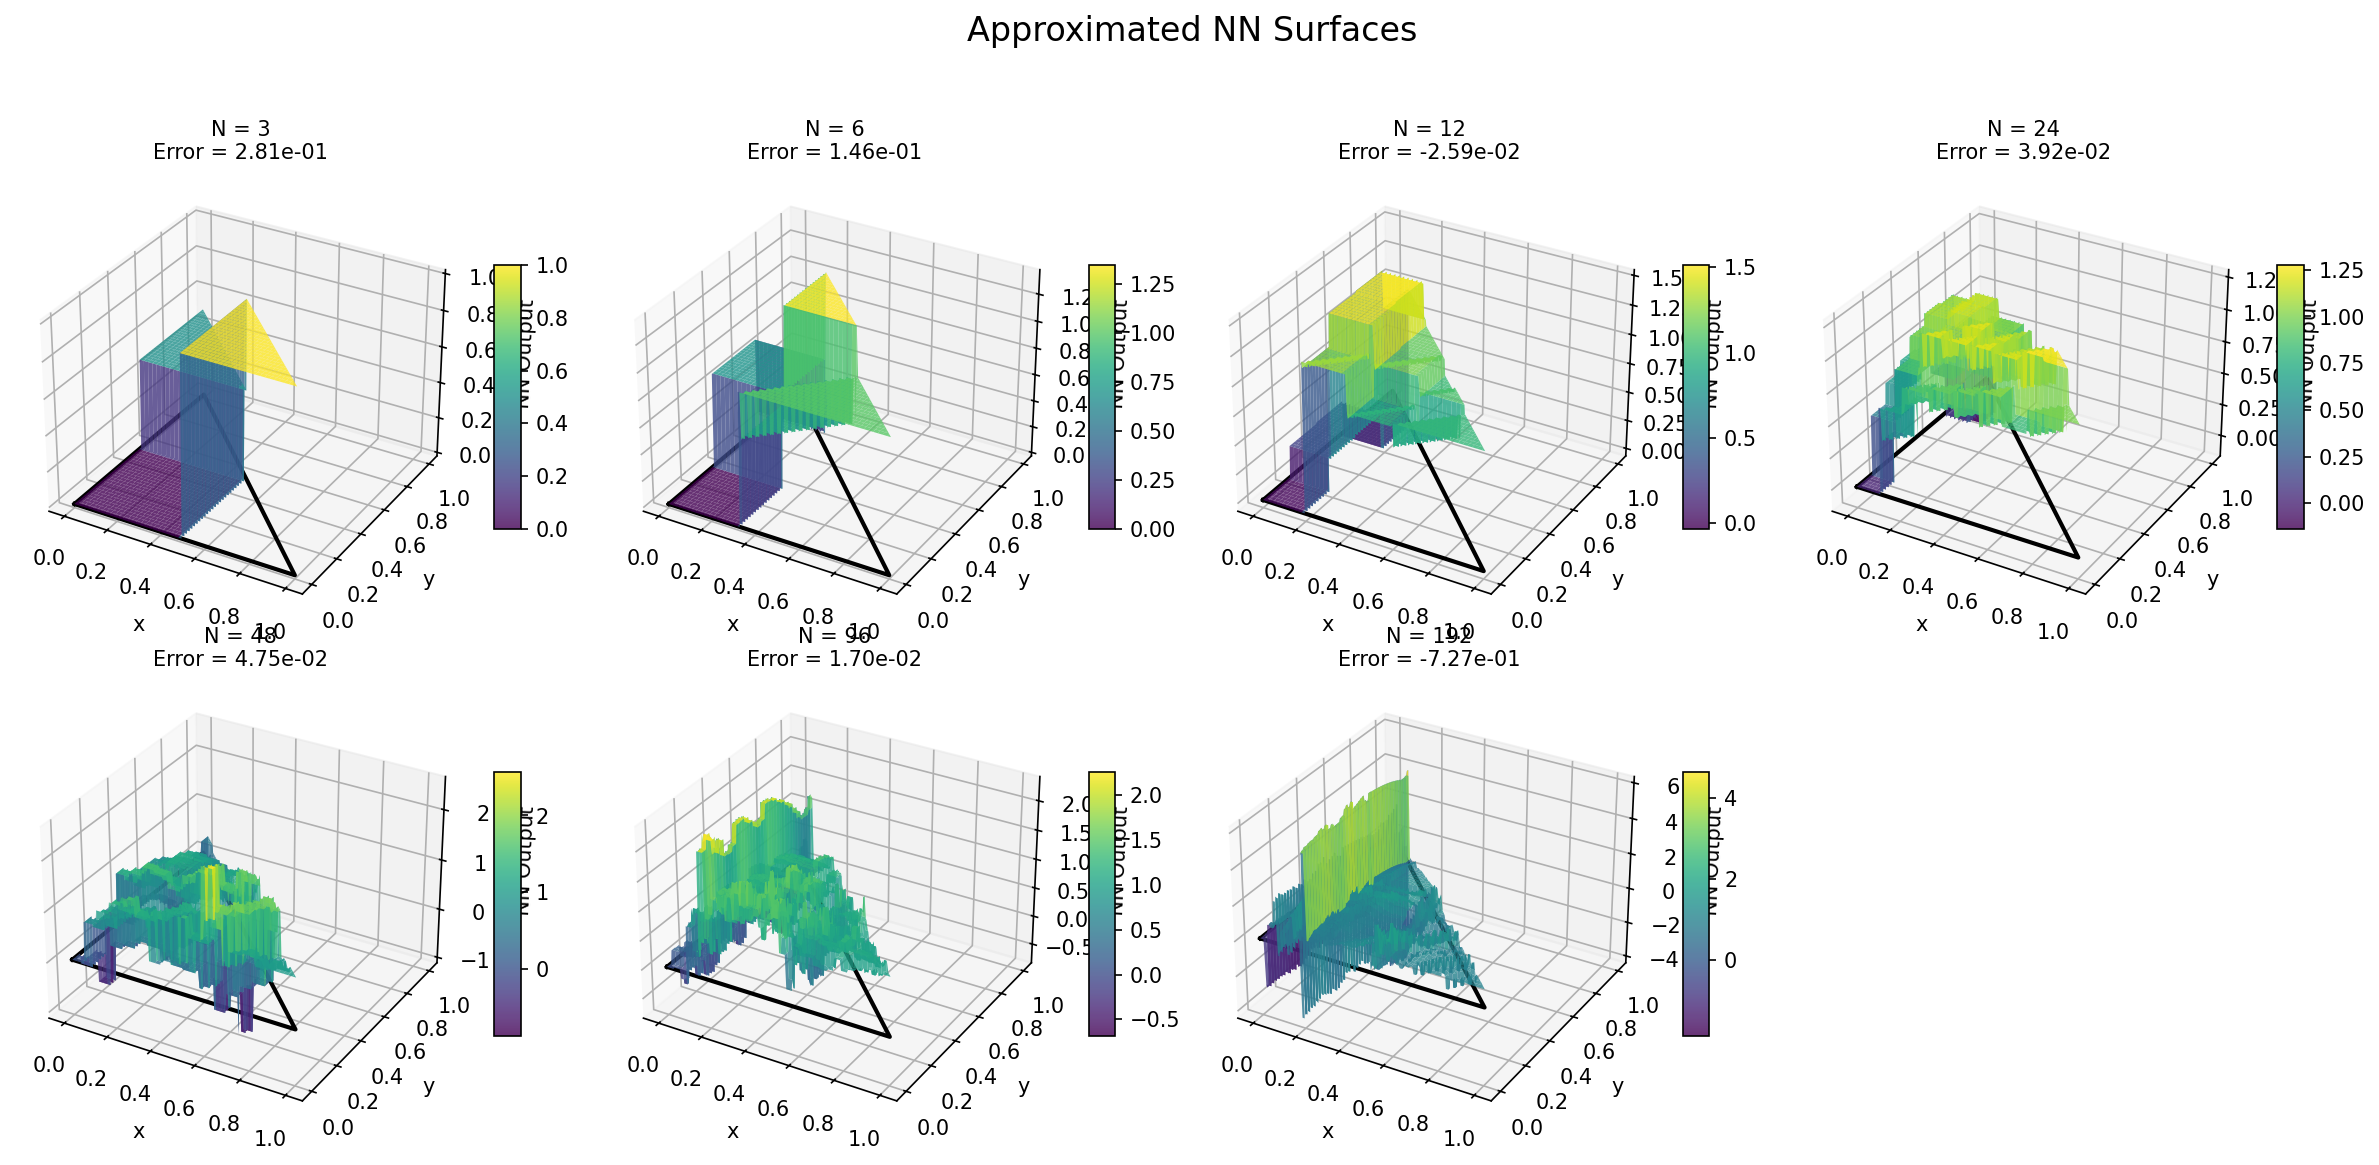

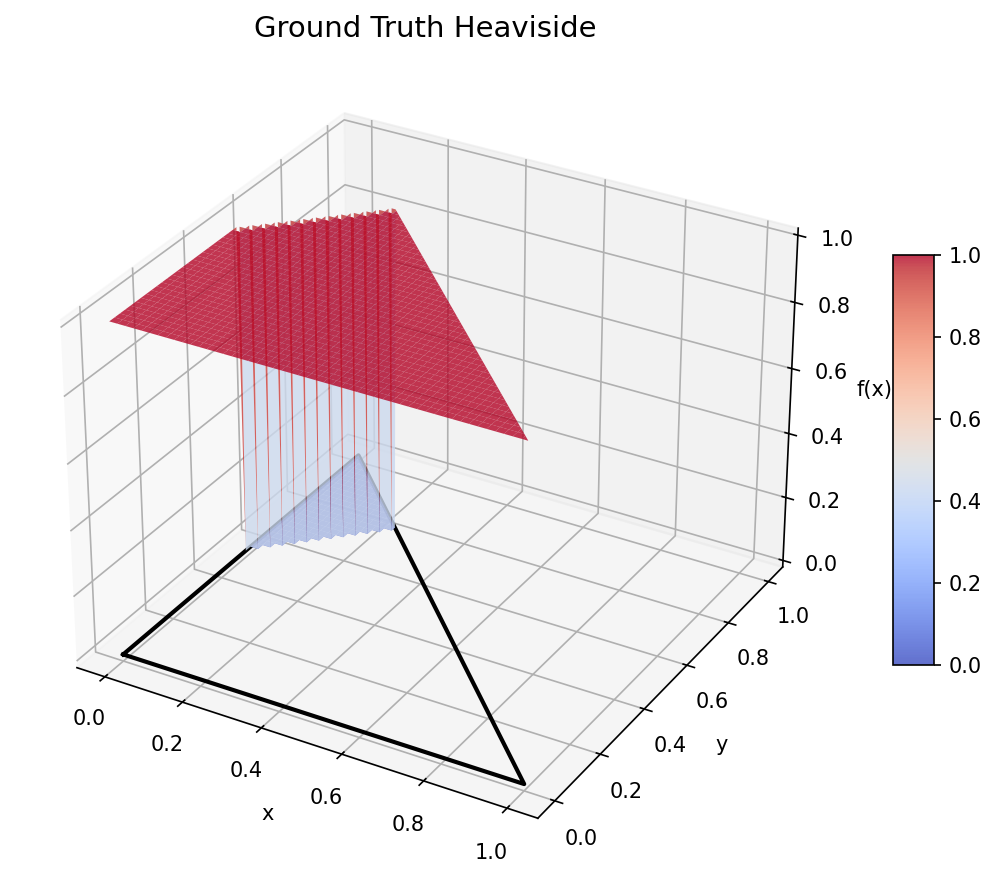

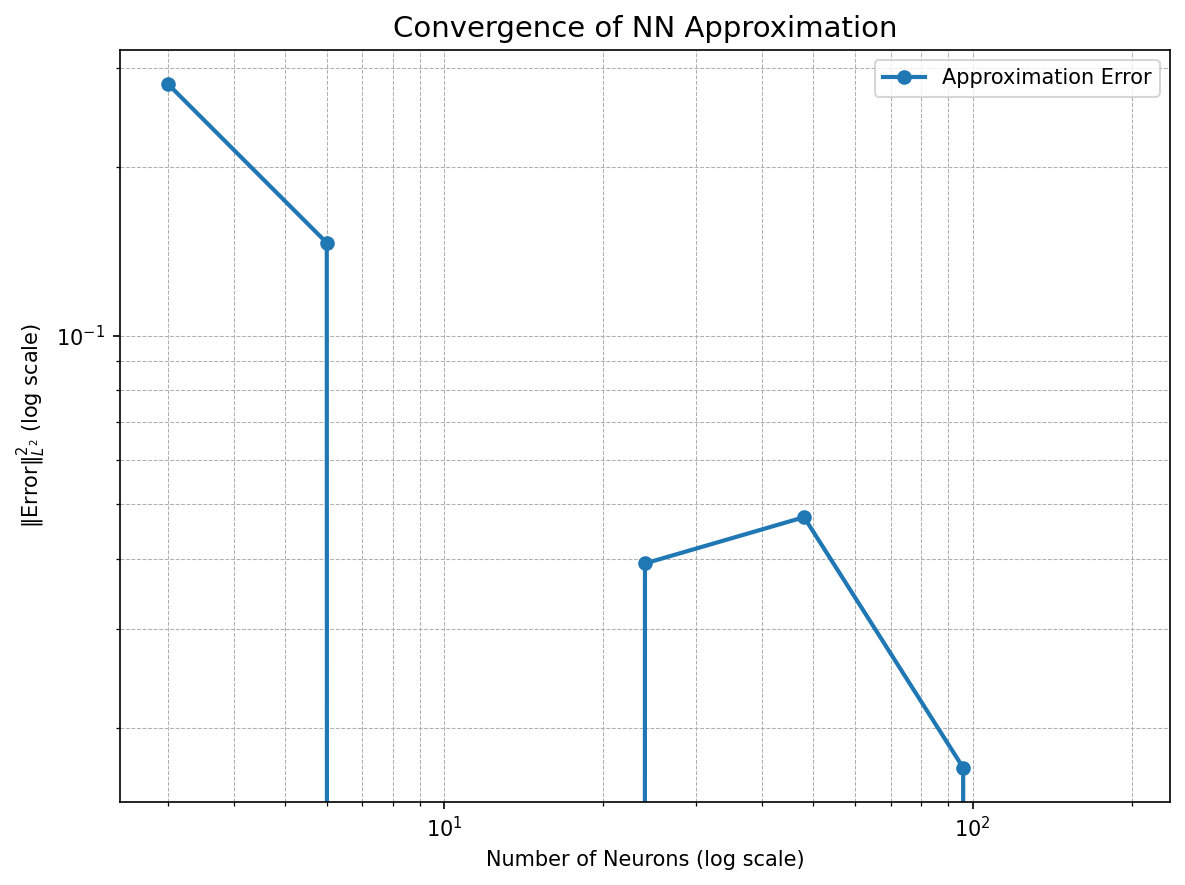

========== MAIN ==========
Final MassMatrix:
[[0.32       0.18       0.08       0.02       0.18       0.08
  0.02       0.         0.16       0.         0.04       0.01      ]
 [0.18       0.18       0.08       0.02       0.08       0.02
  0.         0.         0.14       0.         0.04       0.01      ]
 [0.08       0.08       0.08       0.02       0.02       0.
  0.         0.         0.08       0.13416408 0.04       0.01      ]
 [0.02       0.02       0.02       0.02       0.         0.
  0.         0.         0.02       0.02       0.02       0.01      ]
 [0.18       0.08       0.02       0.         0.32       0.18
  0.08       0.02       0.04       0.04       0.         0.        ]
 [0.08       0.02       0.         0.         0.18       0.18
  0.08       0.02       0.         0.         0.         0.        ]
 [0.02       0.         0.         0.         0.08       0.08
  0.08       0.02       0.         0.         0.         0.        ]
 [0.         0.         0.         0.     

In [42]:
# =============================================================================
# Configuration
# =============================================================================
MAX_ITERATIONS = 7
INITIAL_NEURONS = 3
W_F = np.array([1.0, -1.0])  # Fixed function weights for f(x)
B_F = -0.5

#W_F = np.array([1.0, -1.0])  # Fixed function weights for f(x)
#B_F = -1.0

# Domain boundaries (in a^T x >= b form)
TRIANGLE_BOUNDARIES = (
    (np.array([1, 0]), 0.0),    # x >= 0
    (np.array([0, 1]), 0.0),    # y >= 0
    (np.array([-1, -1]), -1.0)  # x + y <= 1
)
boundaries, b_coeffs = zip(*TRIANGLE_BOUNDARIES)

# Define the triangle vertices computed from TRIANGLE_BOUNDARIES
triangle_vertices = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [0, 0]  # close the loop
])
triangle_x = triangle_vertices[:, 0]
triangle_y = triangle_vertices[:, 1]
# We'll use z=0 for the domain boundary line
triangle_z = np.zeros_like(triangle_x)

# Create a grid over the domain for plotting.
x = np.linspace(0.0, 1.0, 200)
y = np.linspace(0.0, 1.0, 200)
X, Y = np.meshgrid(x, y)

# =============================================================================
# Containers for storing NN approximation data and convergence results.
# =============================================================================
approx_data = []   # List to store tuples: (Z_NN, num_neurons, error)
results = {'neurons': [], 'error': []}

# =============================================================================
# Loop over iterations to compute NN approximations.
# =============================================================================
for iteration in tqdm(range(MAX_ITERATIONS), desc="Computing NN approximations"):
    num_neurons = INITIAL_NEURONS * (2 ** iteration)

    # Generate hyperplanes (inner parameters) for the current number of neurons.
    W, B = generate_uniform_hyperplanes(num_neurons)

    # Compute the MassMatrix, F vector, and the integral over the domain.
    M, F, area_f = M_F_A(W, B, *boundaries, *b_coeffs, W_F, B_F)


    #print(np.linalg.eig(M))

    # Solve for outer parameters using least squares and clean the solution.
    #c_opt = clean_solution(np.linalg.lstsq(M, F, rcond=None)[0])
    c_opt = clean_solution(np.linalg.solve(M, F))#, rcond=None)[0])
    # Evaluate the NN approximation on the grid.
    Z_NN = np.zeros_like(X)
    for i in range(num_neurons):
        Z_NN += c_opt[i] * np.heaviside(W[i][0] * X + W[i][1] * Y - B[i], 0)
        # Apply the triangular mask to the NN approximation
        mask = (X >= 0) & (Y >= 0) & (X + Y <= 1)
        Z_NN[~mask] = np.nan  # Mask out values outside the triangle

    # Compute error for convergence study.
    error = compute_cost(c_opt, M, F, area_f)
    print(f"Iteration {iteration+1}: Neurons = {num_neurons}, Error = {error:.4e}")

    results['neurons'].append(num_neurons)
    results['error'].append(error)
    approx_data.append((Z_NN, num_neurons, error))

# =============================================================================
# Plot all NN approximations together in a grid of subplots.
# =============================================================================
n_plots = len(approx_data)
n_cols = min(4, n_plots)
n_rows = int(np.ceil(n_plots / n_cols))
fig1 = plt.figure(figsize=(4 * n_cols, 4 * n_rows), dpi=150)

for idx, (Z_NN, num_neurons, error) in enumerate(approx_data):
    ax = fig1.add_subplot(n_rows, n_cols, idx + 1, projection='3d')
    surf = ax.plot_surface(X, Y, Z_NN, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.plot(triangle_x, triangle_y, triangle_z, 'k-', linewidth=2)  # Overlay triangle boundary
    ax.set_title(f'N = {num_neurons}\nError = {error:.2e}', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('NN Output')
    fig1.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
fig1.suptitle('Approximated NN Surfaces', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Approximated_NN_Surfaces.png', dpi=300)
plt.show()

# =============================================================================
# Plot the Ground Truth function (restricted to the triangular domain)
# =============================================================================
Z_true = np.heaviside(W_F[0] * X + W_F[1] * Y - B_F, 0)
# Create a mask for the triangular domain:
mask = (X >= 0) & (Y >= 0) & (X + Y <= 1)
Z_true[~mask] = np.nan  # Set values outside the domain to nan

fig2 = plt.figure(figsize=(8, 6), dpi=150)
ax_true = fig2.add_subplot(1, 1, 1, projection='3d')
surf_true = ax_true.plot_surface(X, Y, Z_true, cmap='coolwarm', edgecolor='none', alpha=0.8)
ax_true.plot(triangle_x, triangle_y, triangle_z, 'k-', linewidth=2)
ax_true.set_title('Ground Truth Heaviside', fontsize=14)
ax_true.set_xlabel('x')
ax_true.set_ylabel('y')
ax_true.set_zlabel('f(x)')
fig2.colorbar(surf_true, ax=ax_true, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig('Ground_Truth_Heaviside.png', dpi=300)
plt.show()

# =============================================================================
# Plot the convergence study results.
# =============================================================================
fig3 = plt.figure(figsize=(8, 6), dpi=150)
plt.loglog(results['neurons'], results['error'], 'o-', linewidth=2, markersize=6, label='Approximation Error')
plt.xlabel('Number of Neurons (log scale)')
plt.ylabel(r'$\|\mathrm{Error}\|_{L^2}^2$ (log scale)')
plt.title('Convergence of NN Approximation', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('convergence_plot.png', dpi=300)
plt.show()

if __name__ == "__main__":
    print("========== MAIN ==========")

    # Define the triangle boundaries
    boundary_1, b1 = np.array([1, 0]), 0.0
    boundary_2, b2 = np.array([0, 1]), 0.0
    boundary_3, b3 = np.array([-1, -1]), -1.0

    # Define hyperplanes
    n = 12
    W, B = generate_uniform_hyperplanes(n)

    #W = np.array([[np.sqrt(2)/2, -np.sqrt(2)/2],[np.sqrt(2)/2, np.sqrt(2)/2]])
    #B = np.array([-0.4, 0.4])

    # Compute the MassMatrix and F vectors
    # MatrixM, F_massmatrix, area_step1 = MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3)
    MatrixM, F_massmatrix, area_step1 = M_F_A(W, B, *boundaries, *b_coeffs, W_F, B_F)
    print("Final MassMatrix:")
    print(MatrixM)

    print("integral over domain for f^2(x) = 1:", area_step1)
    print("F vector (from MassMatrix diagonal):", F_massmatrix)

    # go for maybe some for of QR
    outer_c = np.linalg.inv(MatrixM) @ F_massmatrix
    #outer_c = np.linalg.solve(MatrixM, F_massmatrix)

    outer_c = clean_solution(outer_c)  # <-- CLEAN HERE

    print("Cleaned Outer Parameter:")
    print(outer_c)
    print("==========================")

    print("Final Cost:", compute_cost(outer_c, MatrixM, F_massmatrix, area_step1))

    # Check positive definiteness
    print("\nPositive Definiteness Checks:")
    print(f"Via eigenvalues: {is_positive_definite(MatrixM)}")
    print(f"Via Cholesky: {is_positive_definite_cholesky(MatrixM)}")